# Advanced Lane Finding Project (TestImage Pipeline Part2)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread, imsave

from scipy.ndimage.interpolation import rotate
import platform

%matplotlib inline


## common (helper) function to set threshhold values ##

In [2]:
def threshold(img, thresh_min=0, thresh_max=255):
    # 
    # Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    # 
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    
    return xbinary
    

In [3]:
def rgb2gray(rgb):
    #convert rgb to gray scale
    r, g, b = rgb[:, :,:,0], rgb[:, :,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


In [4]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

In [5]:
def displayImage2x1(originalImage,modifiedImage,origTitle,modTitle,fig_size=(24,9),gray=False):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size )
    f.tight_layout()
    ax1.imshow(originalImage)
    ax1.set_title(origTitle, fontsize=50)
    if gray == True:
        #print("gray image..")
        ax2.imshow(modifiedImage,cmap="gray")
    else:
        ax2.imshow(modifiedImage)
    ax2.set_title(modTitle, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def displayImage2x4(filenames,images,mysubtitle="Display Images",gray=False):

        gs1 = gridspec.GridSpec(4, 2)
        gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
        plt.figure(figsize=(26,22))
        plt.suptitle(mysubtitle, fontsize=24)
        for i in range(8):
            ax1 = plt.subplot(gs1[i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            #img = transform_image(image,20,10,5,brightness=1)

            #plt.tight_layout()
            plt.subplot(4,2,i+1)
            if gray:
                plt.imshow(images[i], cmap = "gray")
            else:
                plt.imshow(images[i])
            plt.title(filenames[i],fontsize=18)
            plt.axis('off')

        plt.show()

def showImageListX(images_list, images_label, cols= 2, fig_size=(26, 22)):

    rows = len(images_list)
    fig, ax1 = plt.subplots(rows, cols,figsize=fig_size)
    fig.subplots_adjust(hspace=0.4, wspace=0.0)
    for i in range( rows * cols):
        r = i // cols
        c = i % cols
        #print(r,c)
        ax1[r,c].set_xticklabels([])
        ax1[r,c].set_yticklabels([])
        ax1[r,c].imshow(images_list[r][c])
        ax1[r,c].set_title(images_label[r][c],fontsize=22)
        ax1[r,c].autoscale(False)
        ax1[r,c].axis('off')
    

    fig.tight_layout()
    plt.show()
        
def showImageList(images_list, images_label, cols=2, fig_size=(26, 22) ): #, show_ticks=True):

    rows = len(images_list)
    gs = gridspec.GridSpec(rows, cols)
    gs.update(hspace=0.3,wspace=0.07)
    fig1 = plt.figure(figsize=fig_size)
    ax = []
    cmap = None
    for i in range( rows * cols):        
        r = (i // cols)
        c = i % cols

        img = images_list[r][c]
        lbl = images_label[r][c]
        
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))        
        
        ax.append(fig1.add_subplot(gs[r, c]))
        ax[-1].set_title('%s' % str(lbl))
        
        ax[-1].imshow(img, aspect="auto", cmap=cmap)
        #ax[-1].axis("off")
    plt.show()
    

## Load calibration files ##

In [6]:
# read chess board images 
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
print(imagefiles)

['./camera_cal/calibration5.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration8.jpg']


## Load Test Images from directory

In [7]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

# then display 2x4

filenames = sorted(os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )
#displayImage2x4(filenames,images, "Original Test Images = 8 images ")

## load saved pickle camera calibration parameters ##

In [8]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


## Undistort image of  all testing images ##

***

* some of images are slightly cut from bottom line when applying cv2.undistort based on camera calibration parameters


In [9]:
#
#  with cv2 undistort :
#  input parameters       image
#                         mtx    <---- from camera calibration (pickle file)
#                         dist   <---- from camera calibration (pickle file)
#
#  images <-- skimage.io.image process (RGB format)
#
undist_images = list(map(lambda image:cv2.undistort(image, mtx, dist, None, mtx), np.copy(images) ) )   
undist_images_gray = list(map(lambda img:cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), np.copy(undist_images) ) )   


In [10]:
undistort_filenames = list(map( lambda x:"undistort_"+x , np.copy(filenames) ))


In [11]:
print(filenames,undistort_filenames)

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg'] ['undistort_straight_lines1.jpg', 'undistort_straight_lines2.jpg', 'undistort_test1.jpg', 'undistort_test2.jpg', 'undistort_test3.jpg', 'undistort_test4.jpg', 'undistort_test5.jpg', 'undistort_test6.jpg']


In [12]:
images_list =  np.asarray(list( zip(images,undist_images) ))
images_label =  np.asarray(list( zip(filenames,undistort_filenames) ))

## Compare normal image vs undistortion image based on camera Caribration

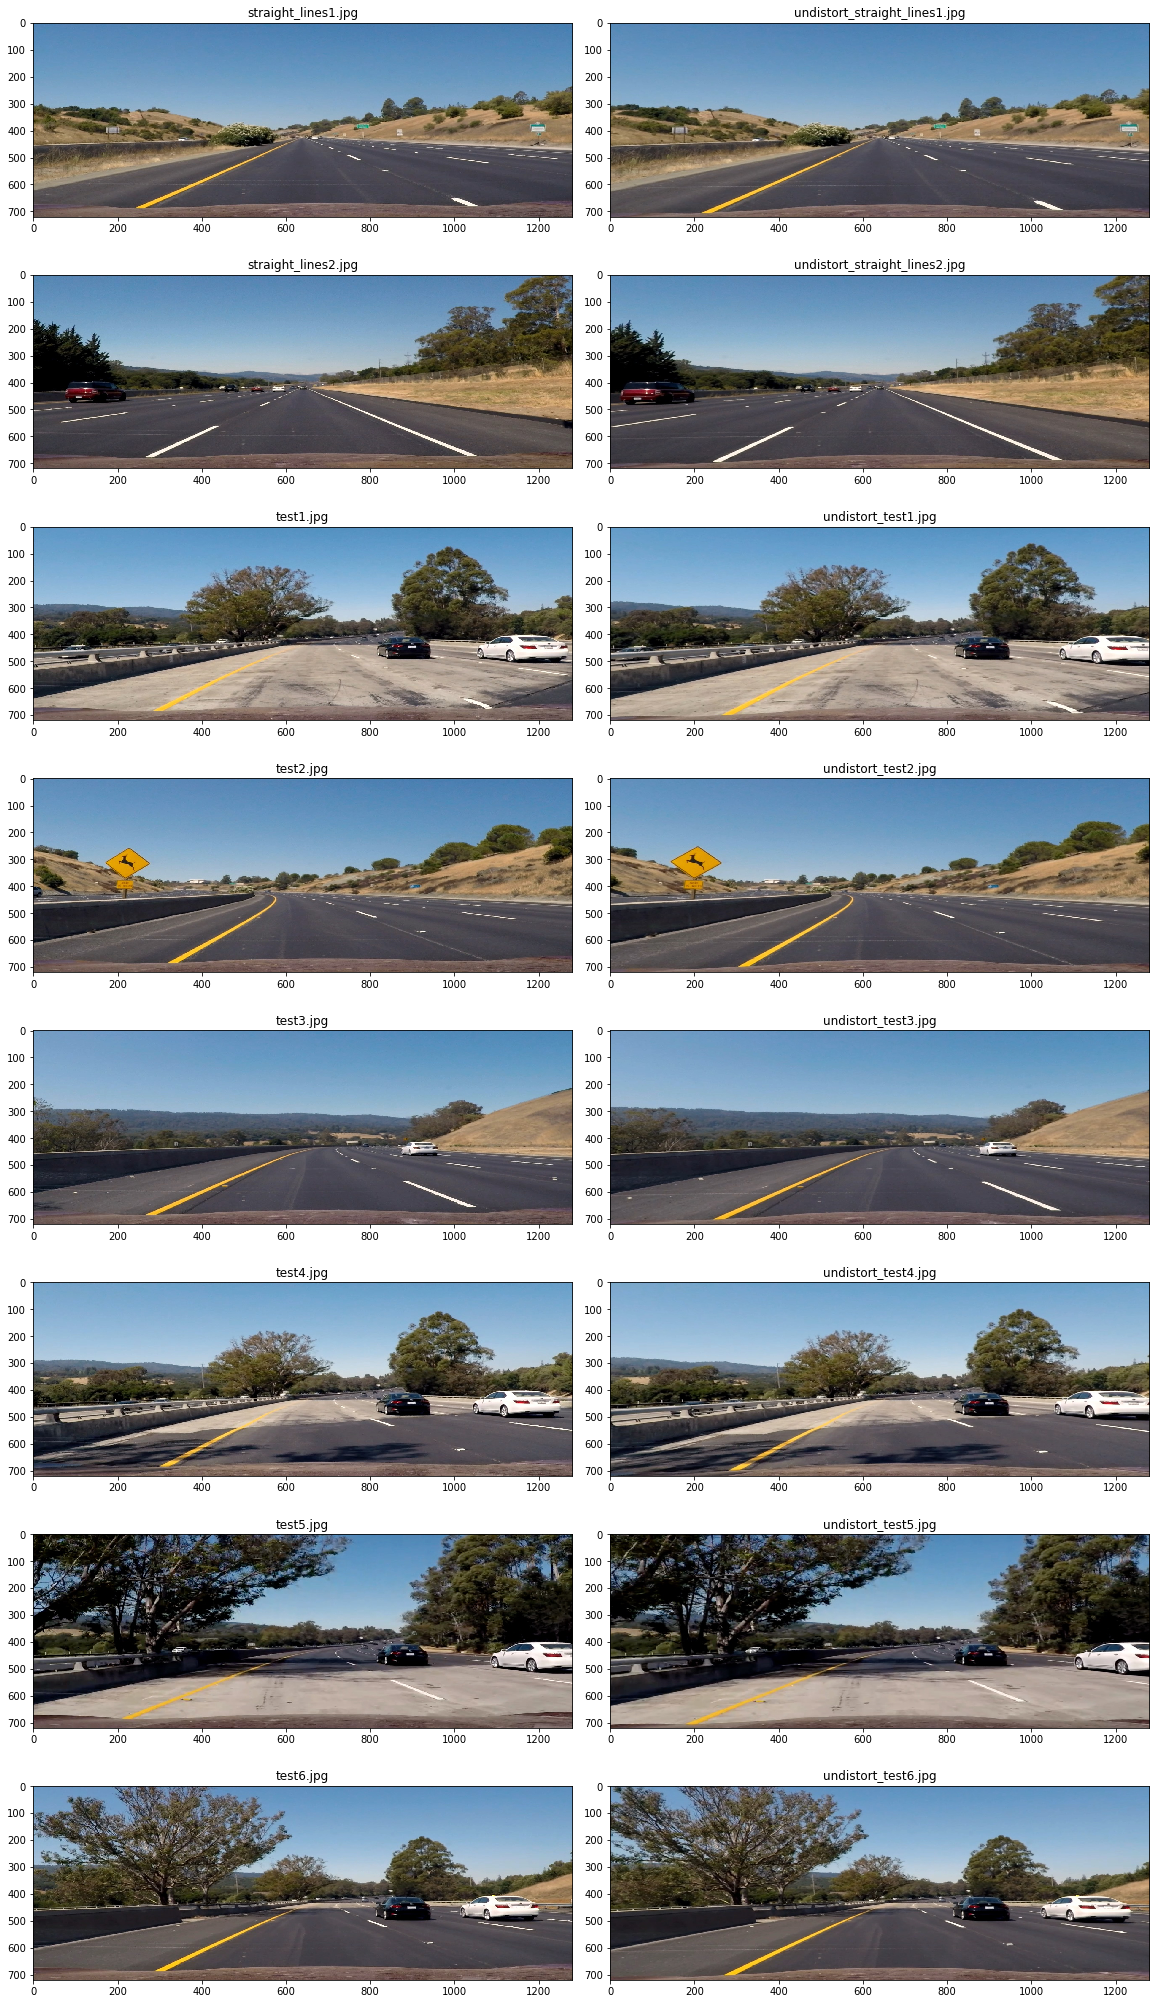

In [13]:
showImageList(images_list, images_label,cols=2,fig_size=(20, 36) )

* After undisting original images, some of those newly images have less data on side windows, for example looking at carefully
the back of the white car is bit lack on undistort_test4.jpg   

In [24]:
#filename = filenames[0]
#mytest_image = imread( os.path.join("test_images",  filename  ) )
#binary = np.zeros_like(mytest_image)
#binary2 = binary.copy()
mytest_image = undist_images[0]
#eq_testimage = histogram_equalize(undist_images[0])

#displayImage2x1(mytest_image,eq_testimage,"Original Image","EqualizeHist Image")

# Check RGB Yellow  / White / HLS Yellow Line #

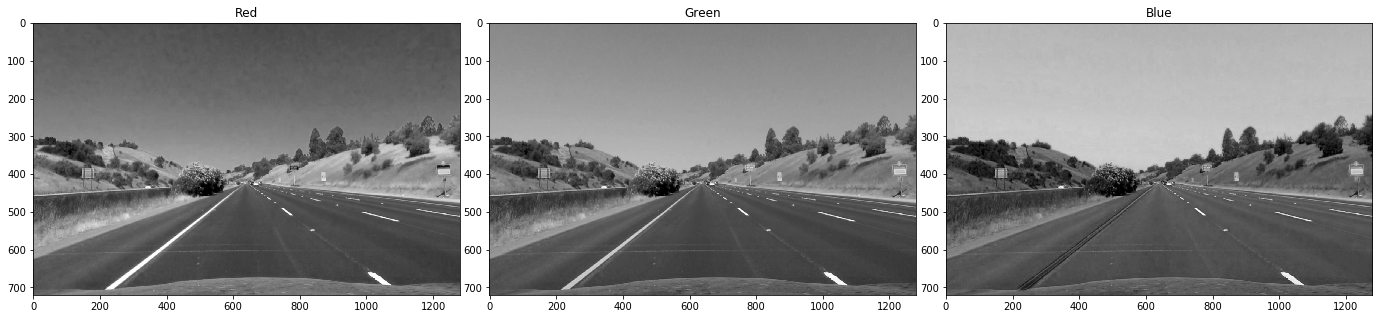

In [25]:
rgb_images = np.asarray([[ mytest_image[:,:,0],mytest_image[:,:,1],mytest_image[:,:,2]]])
rgb_labels = np.asarray([["Red","Green","Blue"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))

* Looking at the above channel images representing Red, Green and Blue, only Blue has poor contrast to draw lane lines on the road. So we could foucs on just both Red and Green channels. 
* Again, we need to extract Yellow and White lane from the road images, then hightlight them to make contrast images from setting threshhold in detail. 

## if apply to set RGB Yellow / White / HLS Yellow line filter to extract yellow & white lane line 

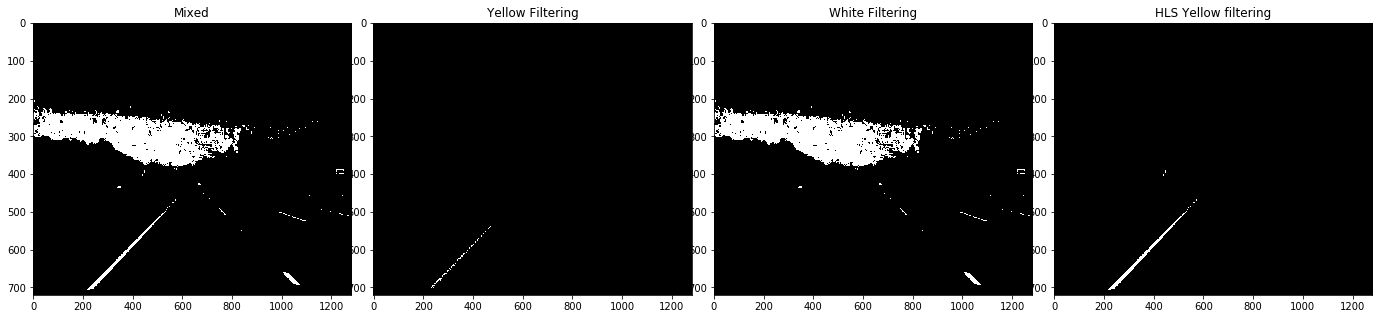

In [26]:
from utils import threshColoredImageBin
    
(binary,y_binary,w_binary,y_hls_binary) = threshColoredImageBin(mytest_image)

mixed_images = np.asarray( [ [ binary,y_binary,w_binary,y_hls_binary  ]  ] )
mixed_labels = np.asarray([["Mixed","Yellow Filtering","White Filtering", "HLS Yellow filtering"]])
showImageList(mixed_images, mixed_labels,cols=4, fig_size=(24,5))    

* As a experiemtal trials to find solution of searching best setting for threshhold parameters, first I have build 3 layers combination for Red, Yellow and HLS Yellow threshhold filtering. We can see 2 white straight lines on the binary image of the above last image, which is extended from the bottom of the image. It is good example to highlight the lane as one of the standard benchmark for further comparisons.
* Next, we go to the gradient threshhold approach like sobel and other advanced technique.

In [16]:
##
## save function
##

def saveImage(targetDir,filename,image):
    savefile = os.path.join(targetDir,filename)
    imsave(savefile,image)
    

In [17]:
targetDir = "undistort"

for fn, undistf in zip(filenames,undist_images):
    saveImage(targetDir,fn,undistf)

FileNotFoundError: [Errno 2] No such file or directory: 'undistort/straight_lines1.jpg'


## review onward project steps ## 
---

*    Camera calibration
*    Distortion correction
*    Color/gradient threshold
*    Perspective transform


## Finding Lanes (Sobel technique X direction) 

In [28]:
from utils import abs_sobel_thresh

In [31]:
sobel3_ops = lambda x:abs_sobel_thresh(x, orient='x', thresh_min=20, thresh_max=100, kernel_size=3)
sobel5_ops = lambda x:abs_sobel_thresh(x, orient='x', thresh_min=20, thresh_max=100, kernel_size=5)
sobel15_ops = lambda x:abs_sobel_thresh(x, orient='x', thresh_min=20, thresh_max=100, kernel_size=15)

sobel3_images = list(map(lambda image:sobel3_ops(image), undist_images) )   
sobel5_images = list(map(lambda image:sobel5_ops(image), undist_images) )
sobel15_images = list(map(lambda image:sobel15_ops(image), undist_images) )

sobel3_labels = list(map( lambda x:"sobel kernelx3"+x , filenames ))
sobel5_labels = list(map( lambda x:"sobel kernelx5"+x , filenames ))
sobel15_labels = list(map( lambda x:"sobel kernelx15"+x , filenames ))

sobel_images_list =  np.asarray(list( zip(sobel3_images,sobel5_images,sobel15_images) ))
sobel_images_label = np.asarray(list( zip(sobel3_labels,sobel5_labels,sobel15_labels) ))

print(sobel_images_list.shape, sobel_images_label.shape)

(8, 3, 720, 1280) (8, 3)


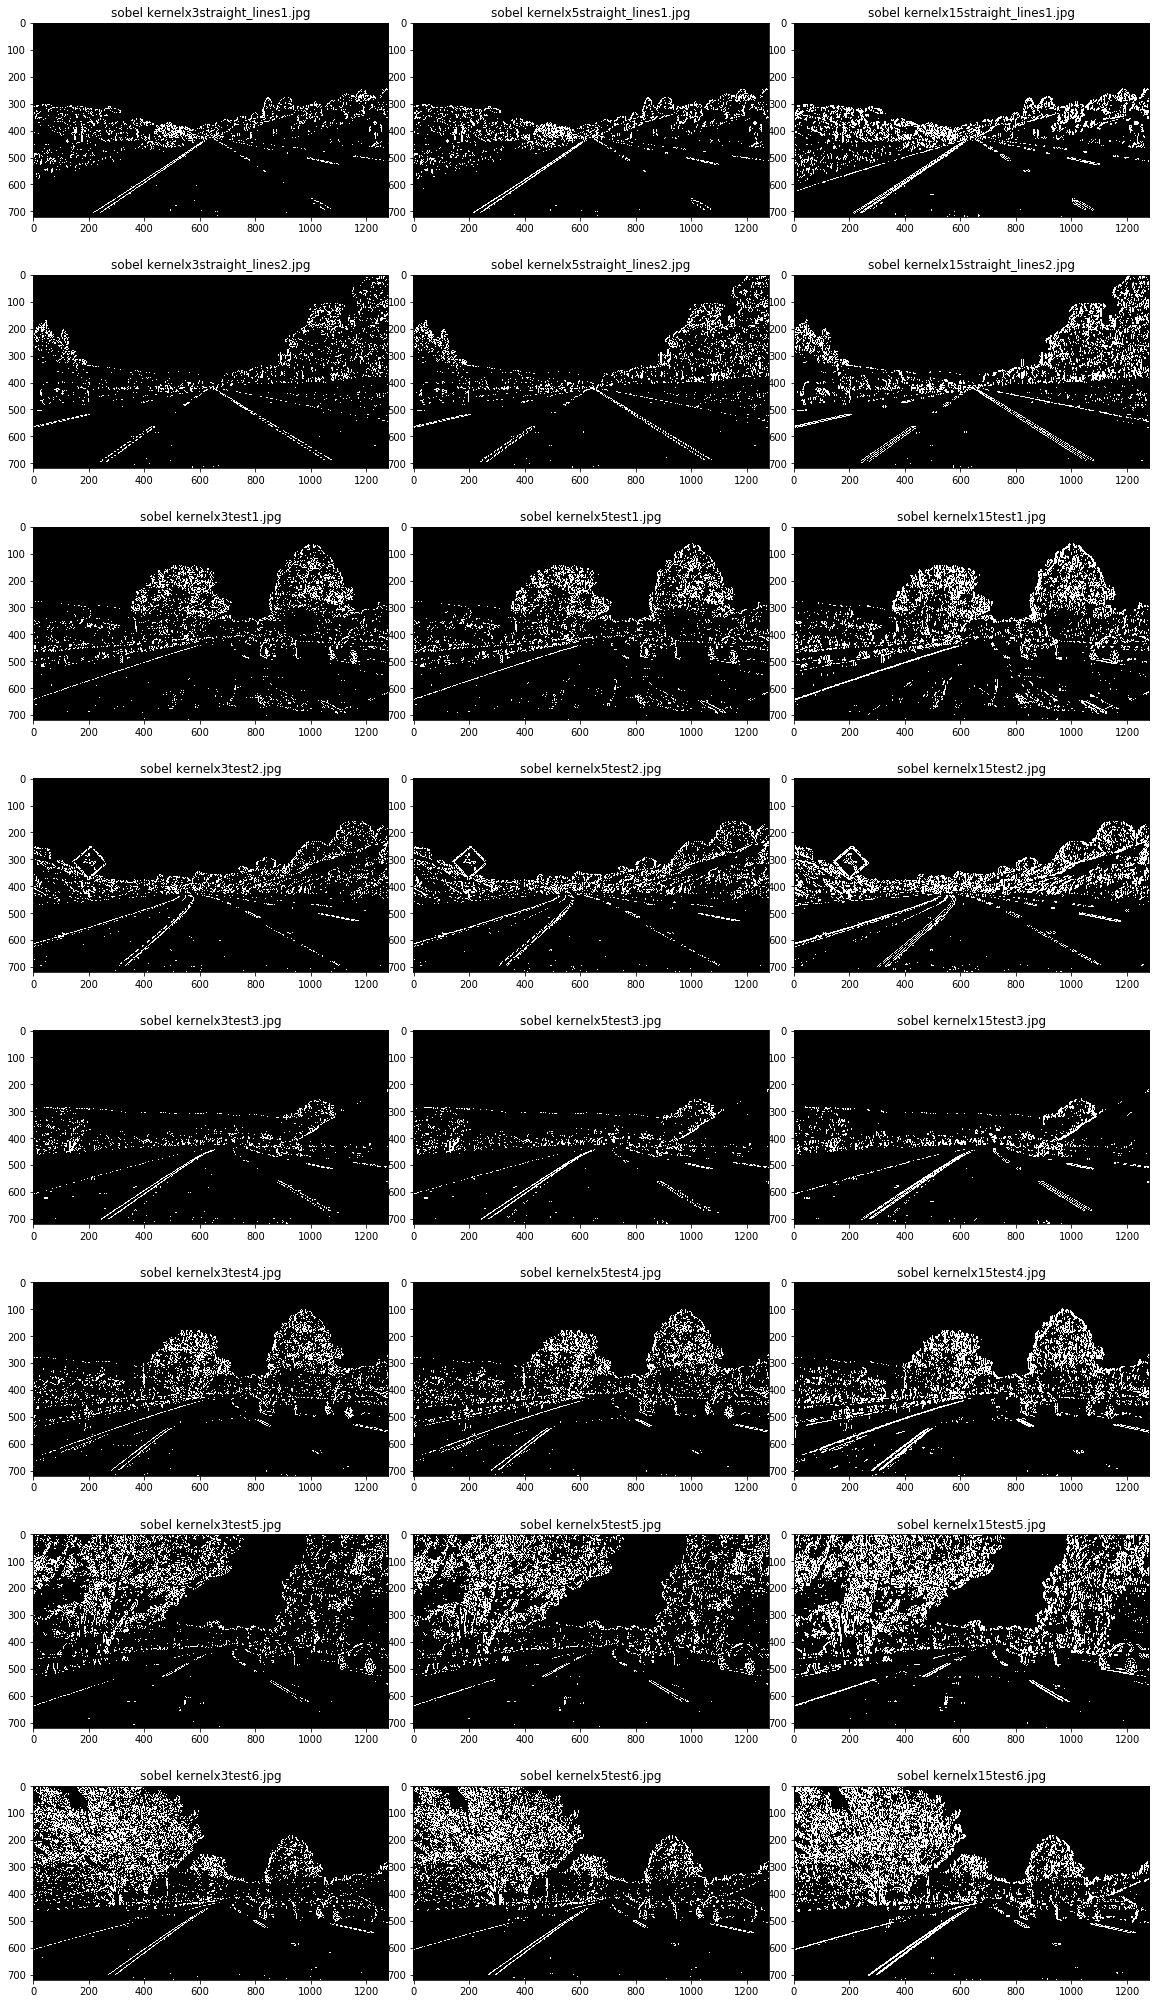

In [32]:
showImageList(sobel_images_list, sobel_images_label,cols=3,fig_size=(20, 36) )

## Finding Lanes (Sobel technique Y direction) 

In [51]:
sobel3_ops = lambda x:abs_sobel_thresh(x, orient='y', thresh_min=20, thresh_max=100, kernel_size=3)
sobel5_ops = lambda x:abs_sobel_thresh(x, orient='y', thresh_min=20, thresh_max=100, kernel_size=5)
sobel15_ops = lambda x:abs_sobel_thresh(x, orient='y', thresh_min=20, thresh_max=100, kernel_size=15)

sobel3_images = list(map(lambda image:sobel3_ops(image), undist_images) )   
sobel5_images = list(map(lambda image:sobel5_ops(image), undist_images) )
sobel15_images = list(map(lambda image:sobel15_ops(image), undist_images) )

sobel3_labels = list(map( lambda x:"sobel y kernelx3 "+x , filenames ))
sobel5_labels = list(map( lambda x:"sobel y kernelx5 "+x , filenames ))
sobel15_labels = list(map( lambda x:"sobel y kernelx15 "+x , filenames ))

sobel_images_list =  np.asarray(list( zip(sobel3_images,sobel5_images,sobel15_images) ))
sobel_images_label = np.asarray(list( zip(sobel3_labels,sobel5_labels,sobel15_labels) ))

print(sobel_images_list.shape, sobel_images_label.shape)

(8, 3, 720, 1280) (8, 3)


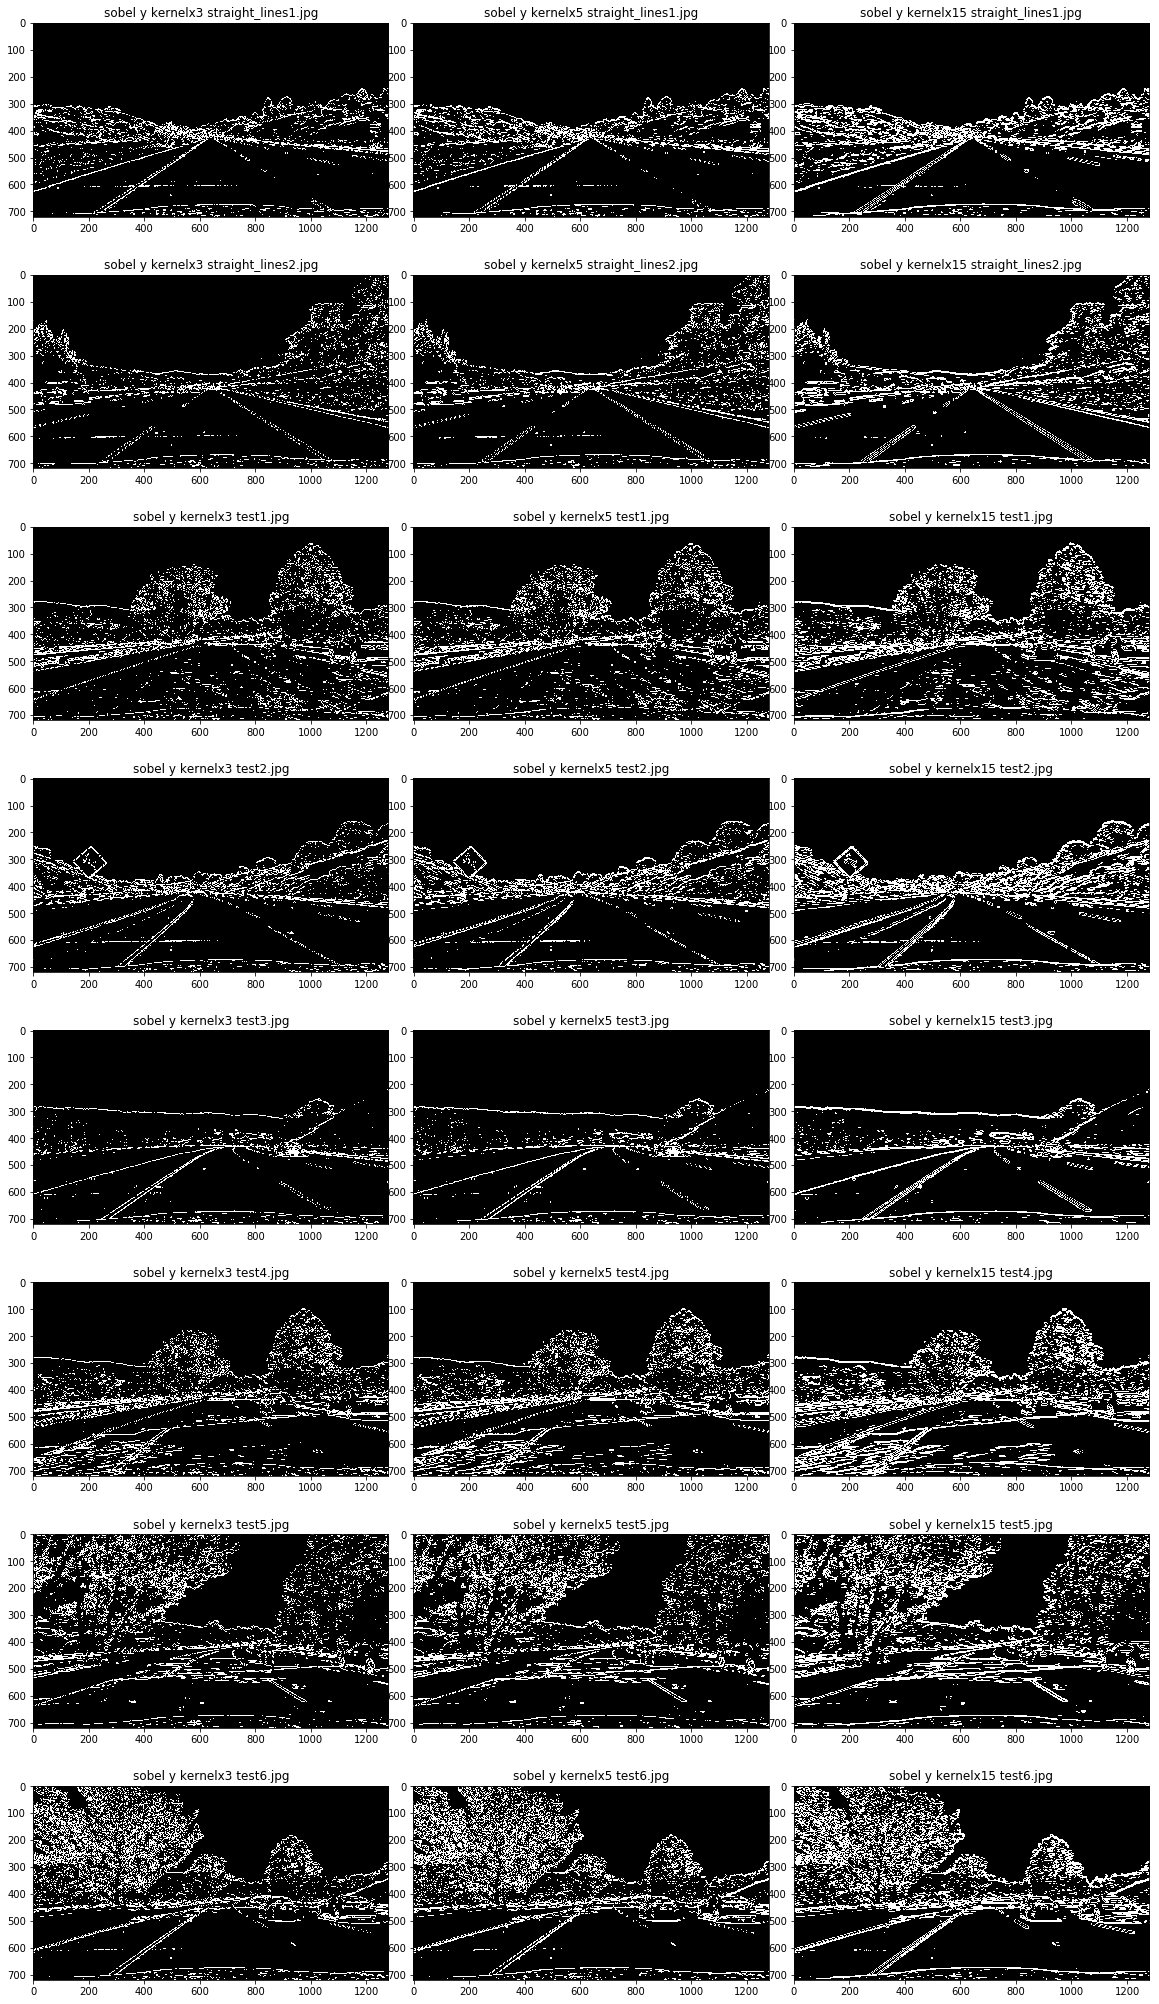

In [52]:
showImageList(sobel_images_list, sobel_images_label,cols=3,fig_size=(20, 36) )

## Finding Lanes (Sobel Magnitude technique) ##

In [33]:
from utils import mag_thresh

In [34]:
mag3_ops = lambda img:mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 150))
mag7_ops = lambda img:mag_thresh(img, sobel_kernel=7, mag_thresh=(50, 150))
mag15_ops = lambda img:mag_thresh(img, sobel_kernel=15, mag_thresh=(50, 150))

mag3_images = list(map(lambda image:mag3_ops(image), undist_images) )   
mag7_images = list(map(lambda image:mag7_ops(image), undist_images) )   
mag15_images = list(map(lambda image:mag15_ops(image), undist_images) )   

mag3_labels = list(map( lambda x:"Magnitude kernel x 3 "+x , filenames ))
mag7_labels = list(map( lambda x:"Magnitude kernel x 5 "+x , filenames ))
mag15_labels = list(map( lambda x:"Magnitude kernel x 15 "+x , filenames ))

mag_images_list =  np.asarray(list( zip(mag3_images,mag7_images,mag15_images) ))
mag_images_label = np.asarray(list( zip(mag3_labels,mag7_labels,mag15_labels) ))

print(mag_images_list.shape, mag_images_label.shape)

(8, 3, 720, 1280) (8, 3)


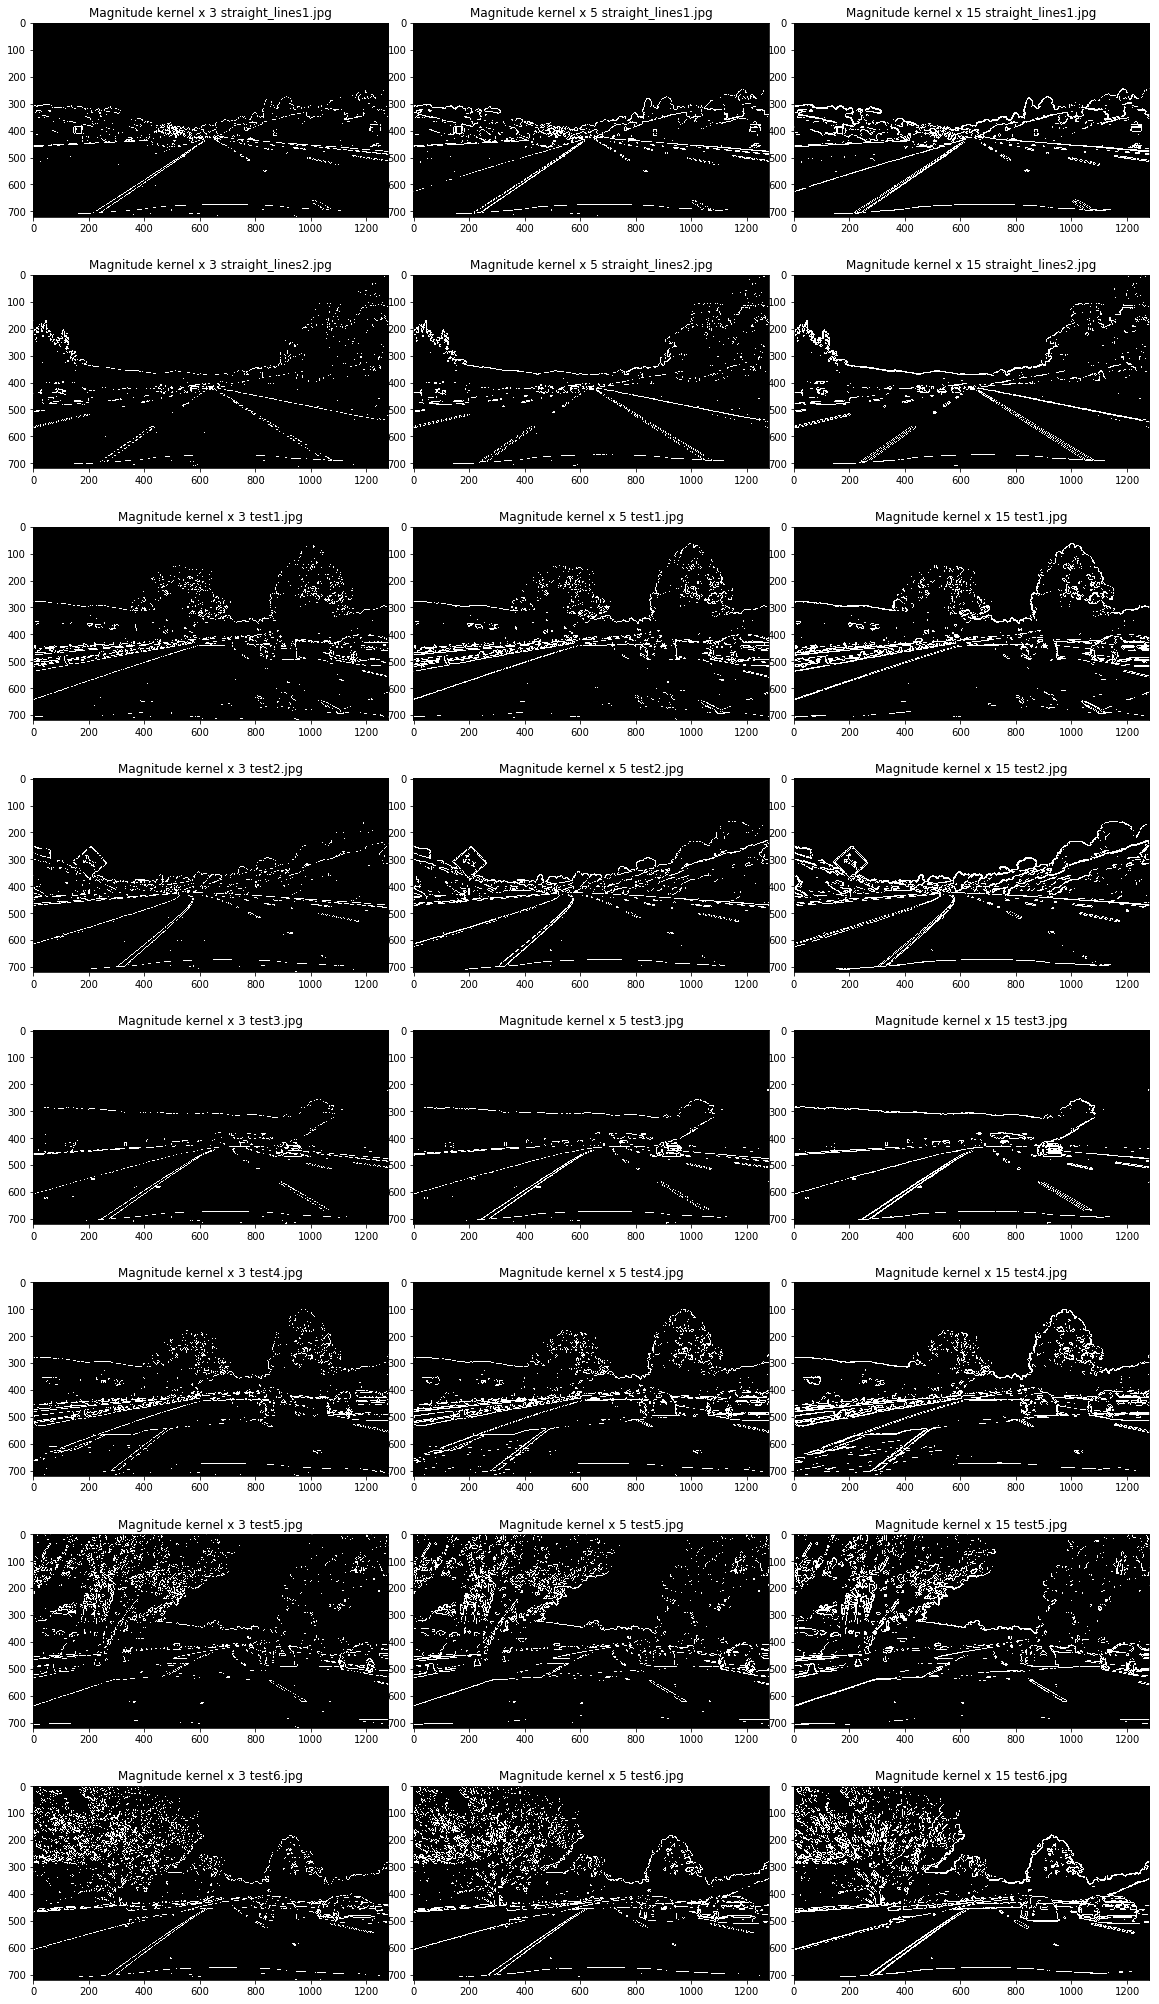

In [35]:
showImageList(mag_images_list, mag_images_label,cols=3,fig_size=(20, 36) )

## Direction of Gradient filter ##

In [42]:
from utils import dir_threshold

In [49]:
dir3_ops = lambda img:dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi / 2))
dir7_ops = lambda img:dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3) )

dir3_images = list(map(lambda image:dir3_ops(image), undist_images) )   
dir7_images = list(map(lambda image:dir7_ops(image), undist_images) )   

dir3_labels = list(map( lambda x:"Direction mag_thresh=(0,np.pi/2) "+x , filenames ))
dir7_labels = list(map( lambda x:"Direction mag_thresh=(0.7, 1.3) "+x , filenames ))

dir_images_list =  np.asarray(list( zip(dir3_images,dir7_images) ))
dir_images_label = np.asarray(list( zip(dir3_labels,dir7_labels) ))

print(dir_images_list.shape, dir_images_label.shape)


(8, 2, 720, 1280) (8, 2)


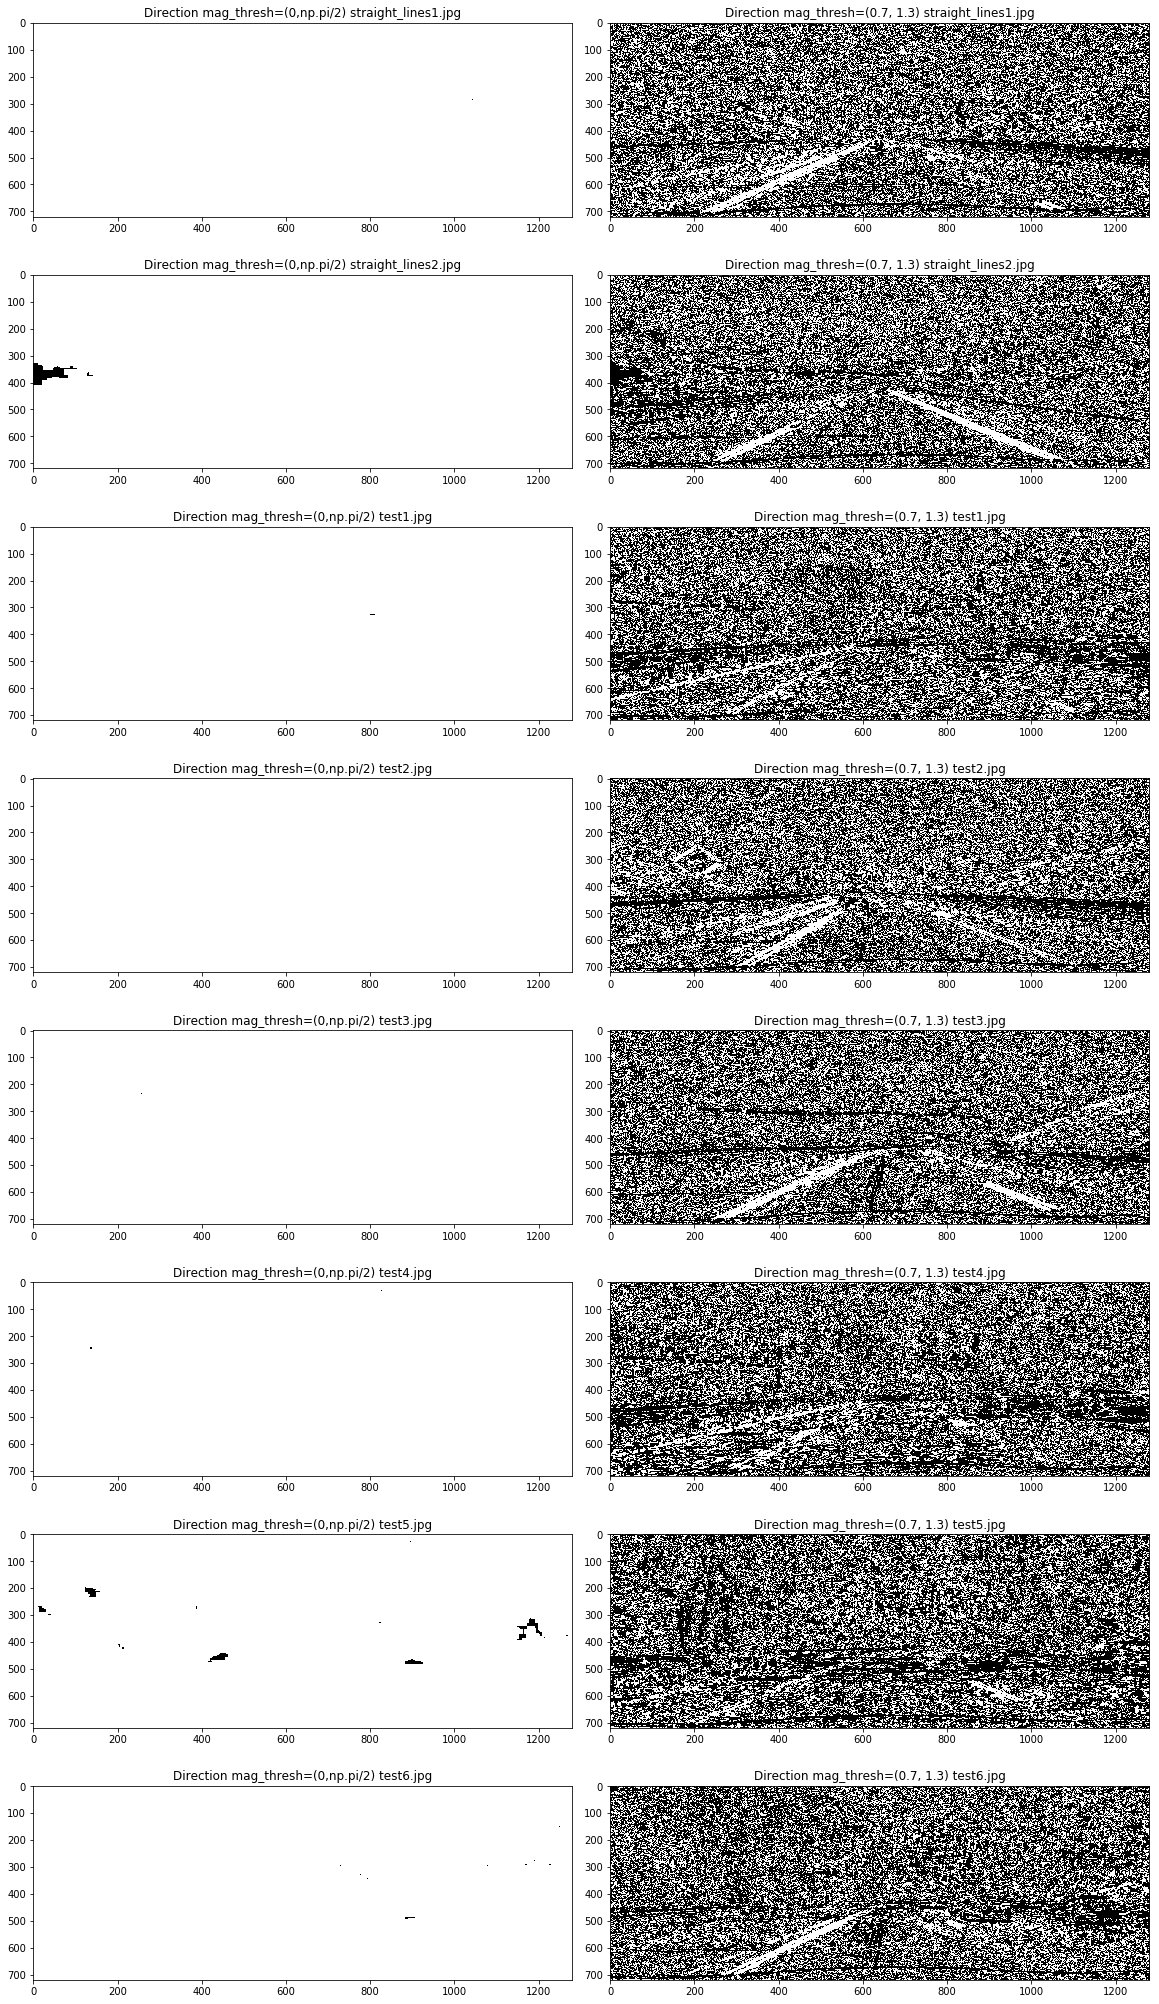

In [50]:
showImageList(dir_images_list, dir_images_label,cols=2,fig_size=(20, 36) )

## Combination Technique (Sobel / Magnitude / Direction of Graditude) ##

In [68]:
def applyCombinedGradient(x):
    
    sobel_imagex = abs_sobel_thresh(x, orient='x', thresh_min=20, thresh_max=120, kernel_size=15)
    #sobel_imagey = abs_sobel_thresh(x, orient='y', thresh_min=20, thresh_max=120, kernel_size=15)

    mag_binary = mag_thresh(x, sobel_kernel=15, mag_thresh=(80, 200))
    dir_binary = dir_threshold(x, sobel_kernel=15, thresh=(np.pi/4, np.pi/2) )
    
    mybinary = np.zeros_like(dir_binary)
    mybinary[ (sobel_imagex == 1) | ( (mag_binary == 1) & (dir_binary == 1)      )      ] = 1
    #mybinary[(sobel_imagex == 1) | ((sobel_imagey == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
    return mybinary

In [69]:
combination_binary_ops = lambda x:applyCombinedGradient(x)
combination_binary_images = list(map(combination_binary_ops,undist_images))

combined_labels = list(map( lambda x:"combined Sobels "+x , filenames ))


combined_images_list =  np.asarray(list( zip(undist_images_gray,combination_binary_images) ))
combined_images_label =  np.asarray(list( zip(filenames,combined_labels) ))

print(combined_images_list.shape, combined_images_label.shape)

(8, 2, 720, 1280) (8, 2)


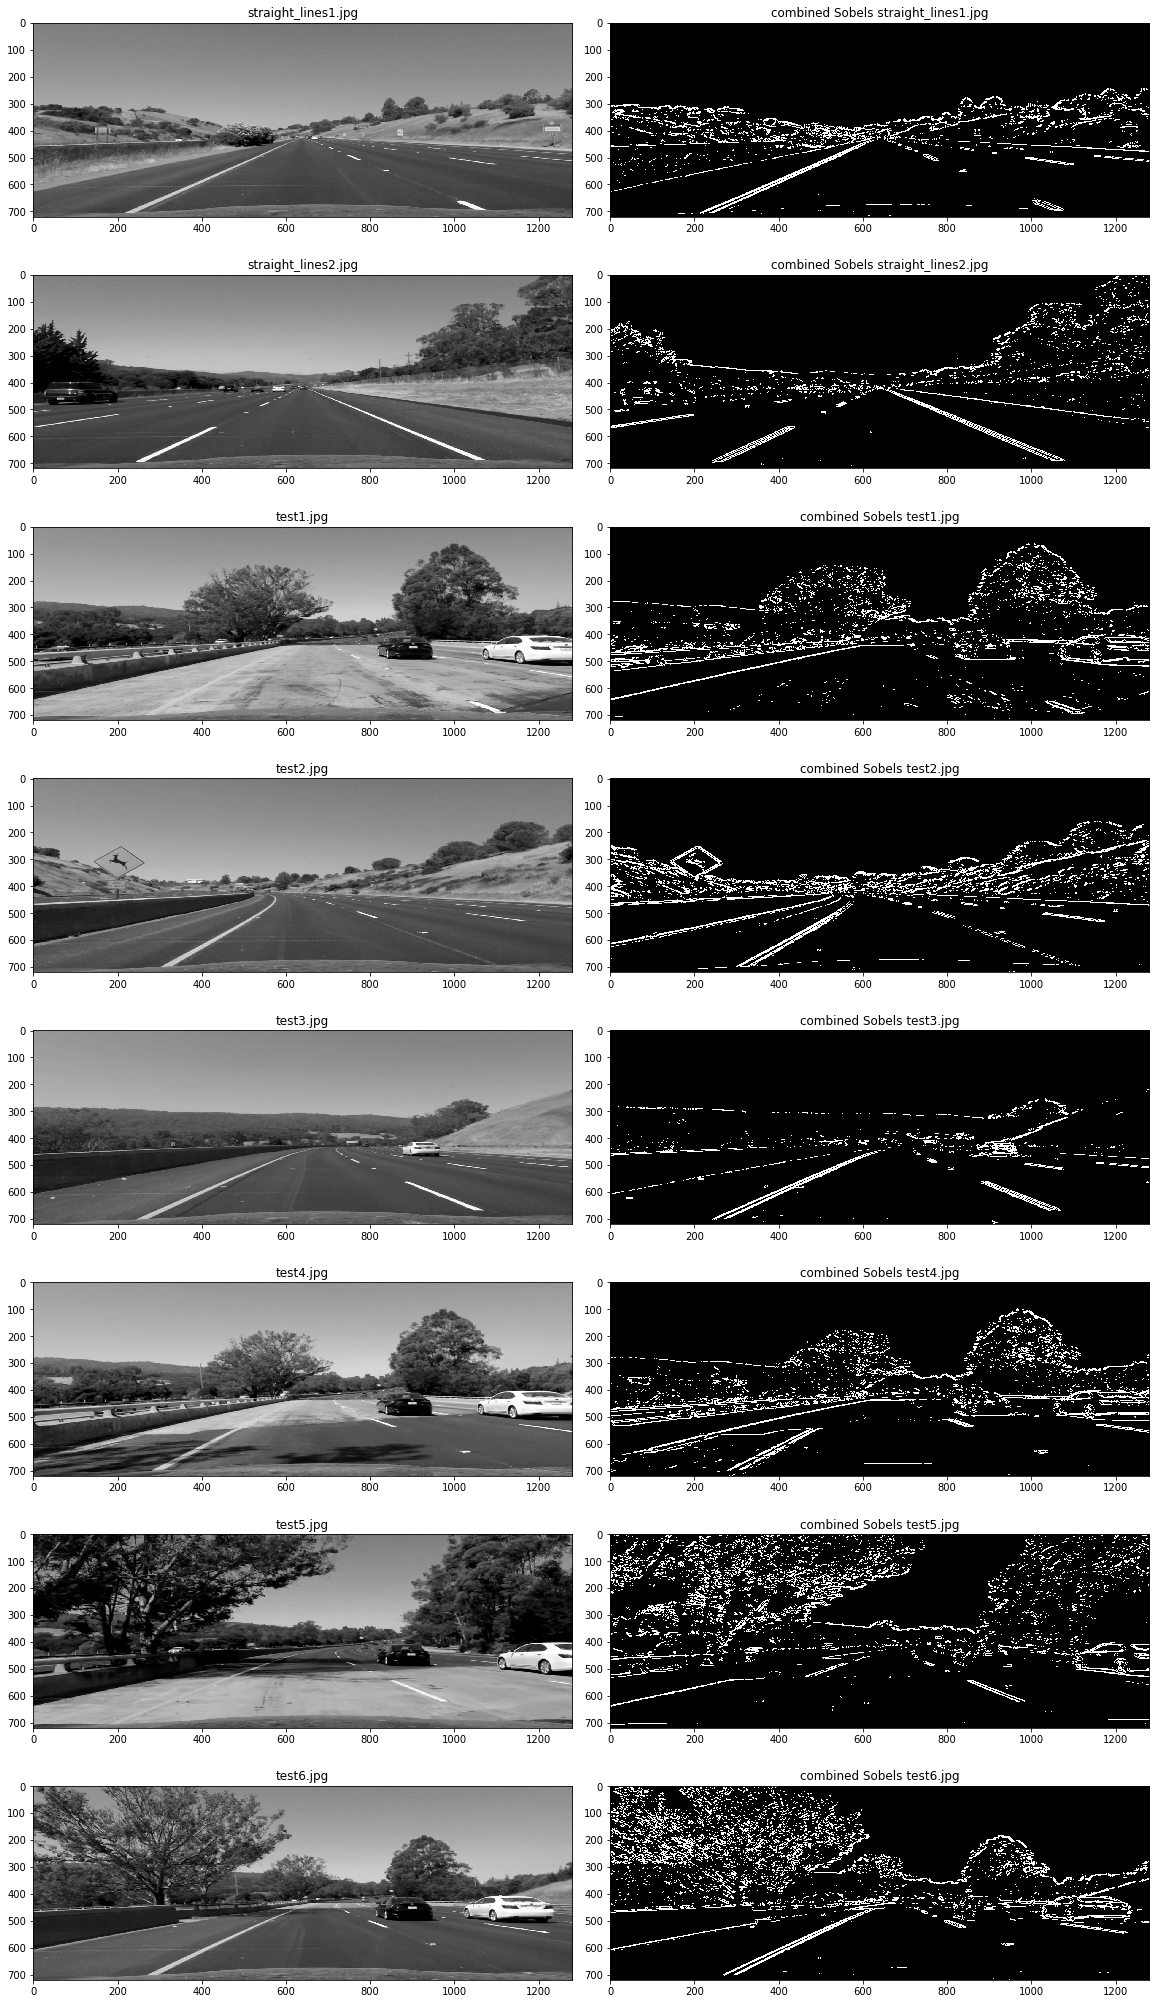

In [70]:
showImageList(combined_images_list, combined_images_label,cols=2,fig_size=(20, 36) )

### By applying several filtering technique on multi layered, lane lines are fairly enough to show, however we cannot extract lane lines of road images in accurate. In a special, test5.jpg has lots of contracts since tree shade is seen on the road, I could not draw lane line with binary image of Sobel / Direction, even combination technique.

## Now try to combine HLS (highlight Yellow and White more )

based on textbook comments

* Saturation also plays a part in this; saturation is a measurement of colorfulness. So, as colors get lighter and closer to white, they have a lower saturation value, whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value. 

So, I will try to extract lane lines with S channel filtering (tweak parameters) 

In [61]:
def s_threshold(img, thresh=(0, 255)):
    
    # input is RGB (skimage.io.imread)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]  # 2 <-- S channel     
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary

In [105]:
def hls_y_w(image):
    
    bin_thresh_min = 20
    bin_thresh_max = 255

    # HLS Yellow masking
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # HLS yellow colored mask
    lower = np.array([20,120,80]).astype(np.uint8)
    upper = np.array([45,200,255]).astype(np.uint8)
    mask = cv2.inRange(hls,lower,upper)
    hls_y = cv2.bitwise_and(image, image, mask=mask)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)    
    gray = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    y_hls_binary = threshold(gray, bin_thresh_min, bin_thresh_max)

    # white colored mask
    lower = np.array([0,200,0]).astype(np.uint8)
    upper = np.array([255,255,255]).astype(np.uint8)
    mask = cv2.inRange(hls,lower,upper)
    hls_w = cv2.bitwise_and(image, image, mask=mask)
    hls_w = cv2.cvtColor(hls_w, cv2.COLOR_HLS2RGB)    
    gray = cv2.cvtColor(hls_w, cv2.COLOR_RGB2GRAY)
    w_binary = threshold(gray, bin_thresh_min, bin_thresh_max)

    binary = np.zeros_like(w_binary)
    binary[ (w_binary == 1) | (y_hls_binary == 1) ] = 1    

    return binary

### Generate HLS Yellow White Filtering and S channel filtering 

In [89]:
hls_y_w_ops = lambda x:hls_y_w(x)
hls_y_w_images = list(map( hls_y_w_ops, undist_images ))

s_ops = lambda x:s_threshold(x ,thresh=(90, 255) )
s_images = list(map( s_ops, undist_images ))



### Build Colored Binary Image to strength highligted lane line 

In [90]:
def makeColorBinary(combined_images, hls_images):
    color_binary_images = []
    for s,h in zip(combined_images, hls_images):
        
        color_binary = np.dstack((np.zeros_like(s), s, h)) * 255
        color_binary = color_binary.astype(np.uint8)
        color_binary_images.append(color_binary)
    
    return color_binary_images

In [97]:
hls_y_w = makeColorBinary(combination_binary_images,hls_y_w_images) # list
s = makeColorBinary(combination_binary_images,s_images) #list


In [99]:
colored_images_list =  np.asarray(list( zip(undist_images,hls_y_w,s) ))

hls_y_w_labels = list(map( lambda x:"HLS Yellow White "+x , filenames ))
s_labels = list(map( lambda x:"S channel Filter "+x , filenames ))
colored_images_label =  np.asarray(list( zip(filenames,hls_y_w_labels,s_labels) ))

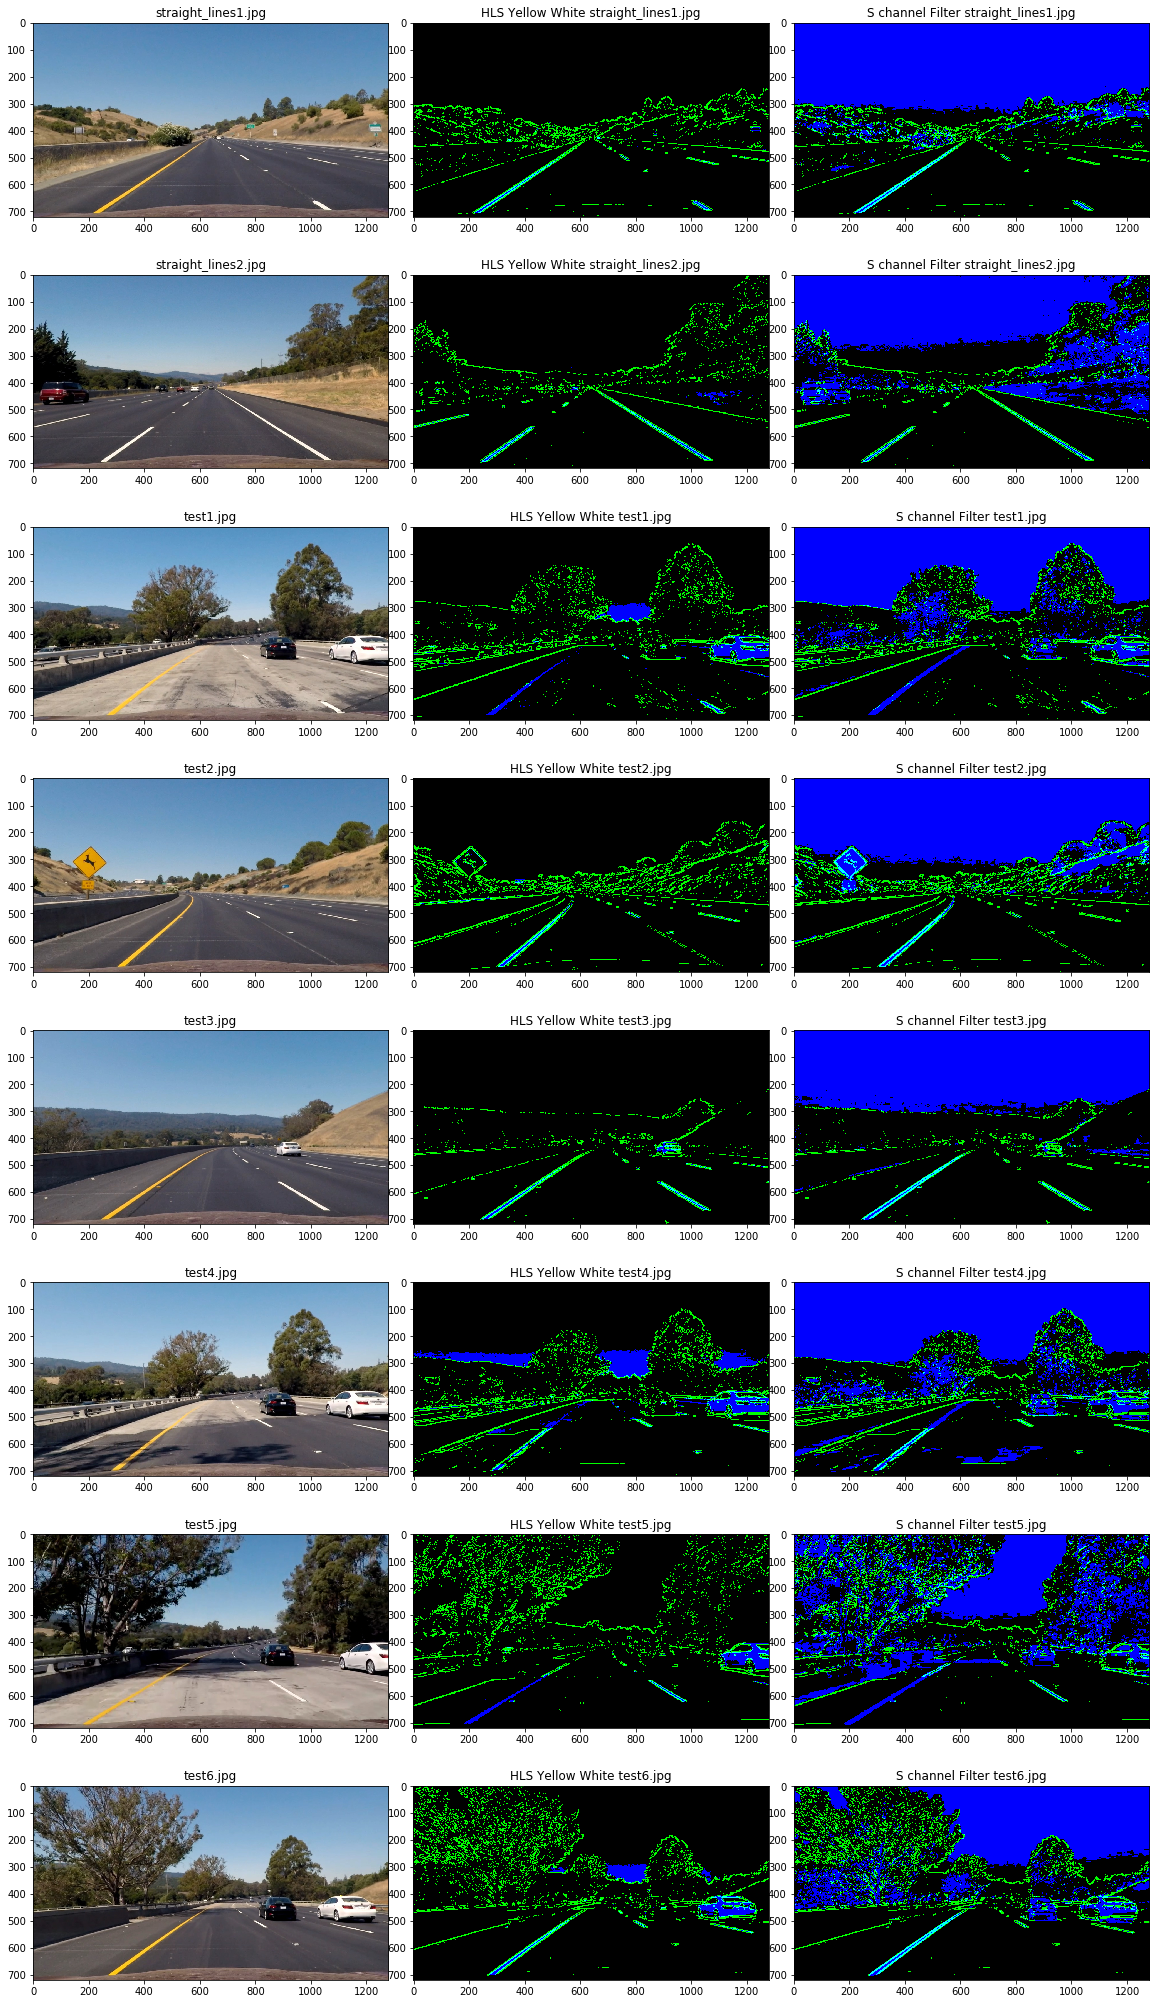

In [100]:
showImageList(colored_images_list, colored_images_label,cols=3,fig_size=(20, 36) )

### Make Bianry Image to integrate Sobel Gradient and HLS Yellow / S channels 

In [101]:
def makeBestCombinedBinaryImages(combined_images, hls_images):

    binary_images = []
    for c,h in zip(combined_images, hls_images):
            
        combined_binary = np.zeros_like(c)
        combined_binary[ (c == 1)  | ( h == 1) ] = 1
        
        binary_images.append(combined_binary)
    
    return binary_images


In [102]:
hls_y_w_binary = makeBestCombinedBinaryImages(combination_binary_images,hls_y_w_images) # list
s_binary = makeBestCombinedBinaryImages(combination_binary_images,s_images) #list

In [103]:
binary_images_list =  np.asarray(list( zip(undist_images_gray,hls_y_w_binary,s_binary) ))

binary_hls_y_w_labels = list(map( lambda x:"HLS Yellow White binary"+x , filenames ))
binary_s_labels = list(map( lambda x:"S channel binary "+x , filenames ))
binary_images_label =  np.asarray(list( zip(filenames,binary_hls_y_w_labels,binary_s_labels) ))

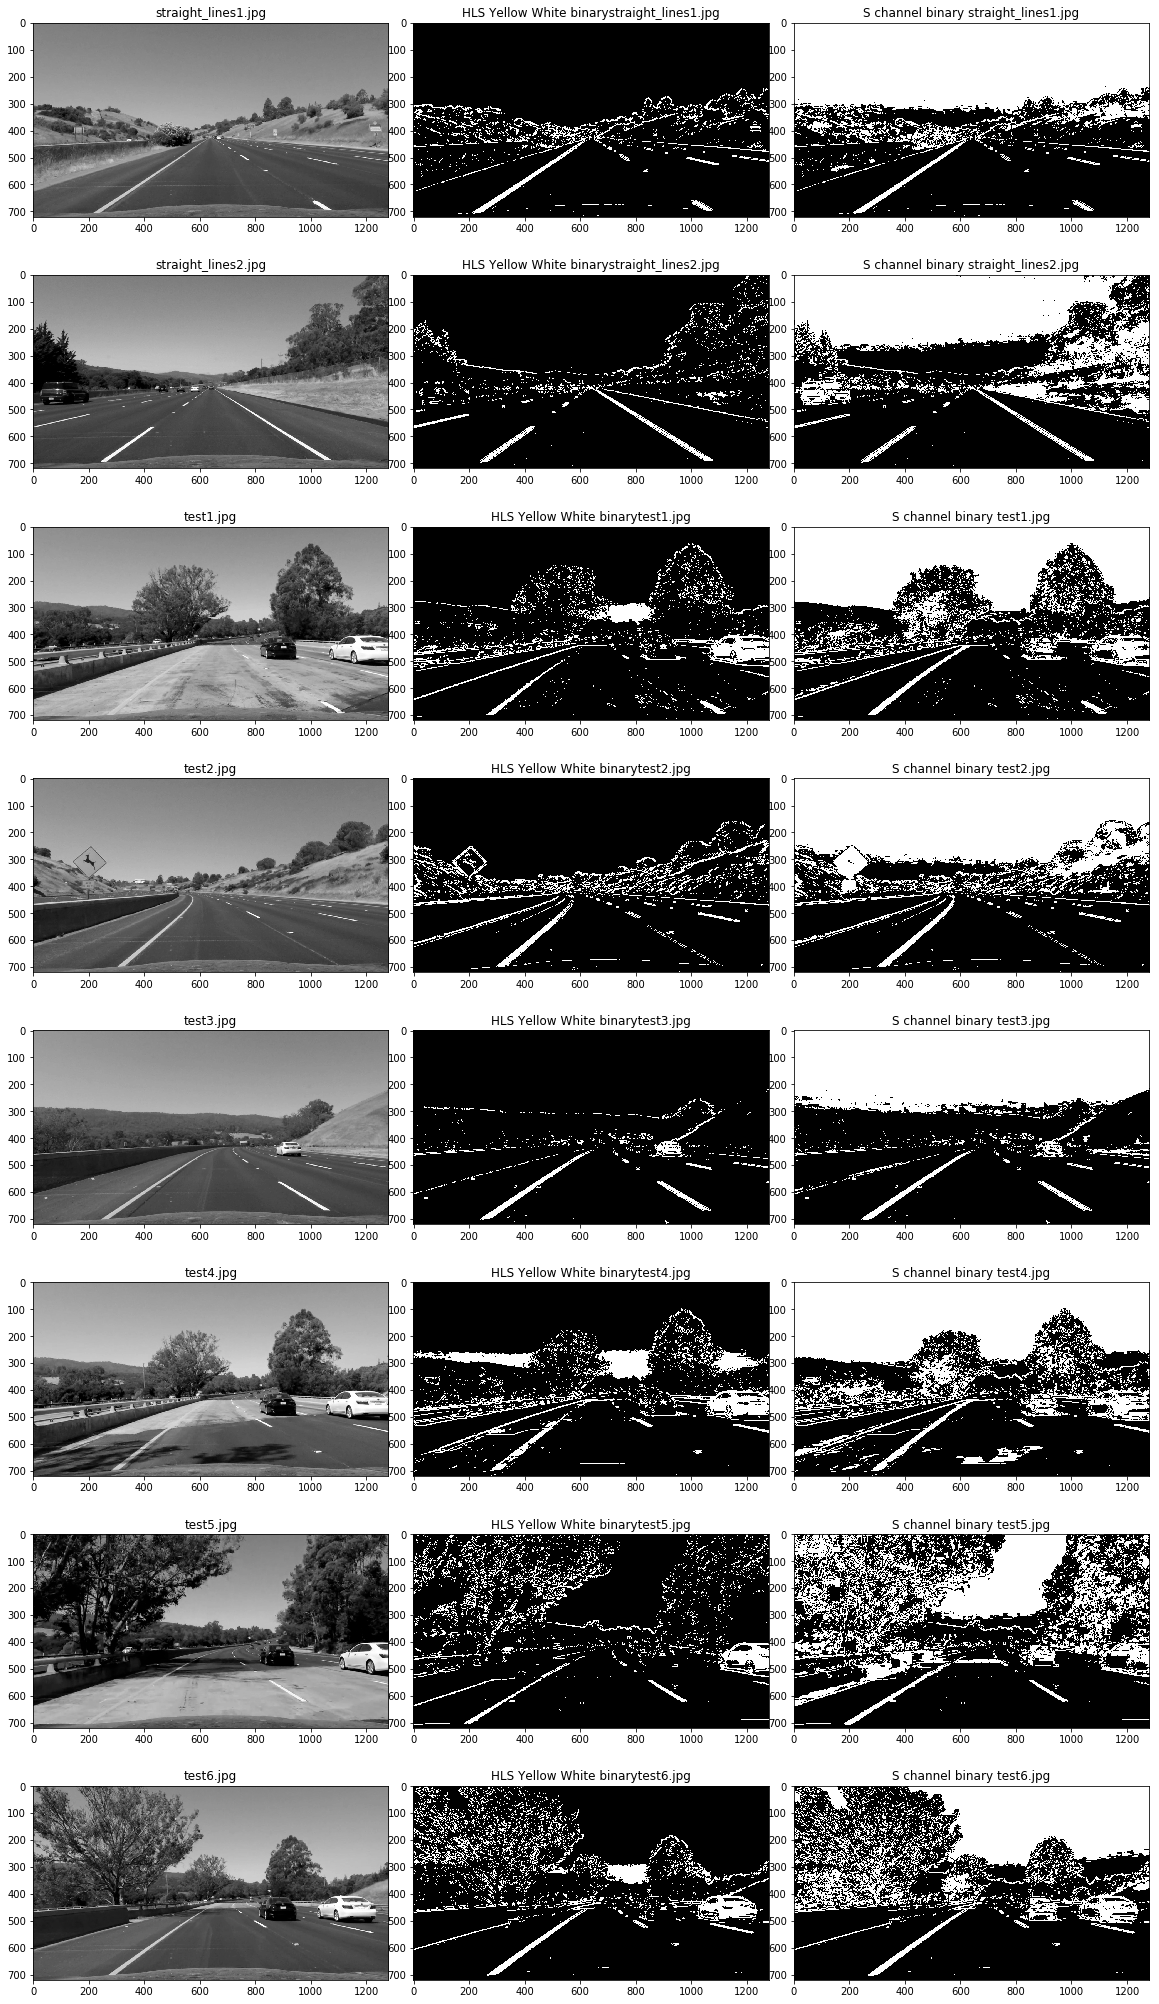

In [104]:
showImageList(binary_images_list, binary_images_label,cols=3,fig_size=(20, 36) )